# LeNet-5: MNIST + PyTorch

- Using Swish activation function, with trainable $\beta$ parameter. Refer to [SWISH: A Self-Gated Activation Function](https://arxiv.org/pdf/1710.05941v1.pdf) paper by Prajit Ramachandran, Barret Zoph and Quoc V. Le.
- Multi-step learning rate scheduler.

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os, pickle
from tqdm import tqdm
from tqdm import trange

In [3]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

torch version: 2.0.0
Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080 Laptop GPU
Available device is cuda


In [4]:
# Specify hyper-parameters
batch_size = 256
num_classes = 10
num_epochs = 90

In [5]:
# MNIST dataset statistics:
# mean = tensor([0.1307]) & std dev = tensor([0.3081])
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std_dev)
    ])
     

# MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
    root = 'C:/Users/arjun/Downloads/data/', train = True,
    transform = transforms_apply, download = True
)

test_dataset = torchvision.datasets.MNIST(
    root = 'C:/Users/arjun/Downloads/data/', train = False,
    transform = transforms_apply
)

In [6]:
# Create dataloader-
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = batch_size,
    shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset, batch_size = batch_size,
    shuffle = False
)

### LeNet-5 CNN architecture

Refer to PyTorch discussion to train scalar parameters [here](https://discuss.pytorch.org/t/scalar-parameters-not-showing-up-in-model-parameters/121450).

In [7]:
class LeNet5(nn.Module):
    def __init__(self, beta = 1.0):
        super(LeNet5, self).__init__()
        
        # Trainable parameter for swish activation function-
        self.beta = nn.Parameter(torch.tensor(beta, requires_grad = True))
        
        self.conv1 = nn.Conv2d(
            in_channels = 1, out_channels = 6, 
            kernel_size = 5, stride = 1,
            padding = 0, bias = False 
        )
        self.bn1 = nn.BatchNorm2d(num_features = 6)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(
            in_channels = 6, out_channels = 16,
            kernel_size = 5, stride = 1,
            padding = 0, bias = False
        )
        self.bn2 = nn.BatchNorm2d(num_features = 16)
        self.fc1 = nn.Linear(
            in_features = 256, out_features = 120,
            bias = True
        )
        self.bn3 = nn.BatchNorm1d(num_features = 120)
        self.fc2 = nn.Linear(
            in_features = 120, out_features = 84,
            bias = True
        )
        self.bn4 = nn.BatchNorm1d(num_features = 84)
        self.fc3 = nn.Linear(
            in_features = 84, out_features = 10,
            bias = True
        )
        
        self.initialize_weights()

        
    def initialize_weights(self):
        for m in self.modules():
            # print(m)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                
                # Do not initialize bias (due to batchnorm)-
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
                
            elif isinstance(m, nn.BatchNorm2d):
                # Standard initialization for batch normalization-
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    
    def swish_fn(self, x):
        return x * torch.sigmoid(x * self.beta)

    
    def forward(self, x):
        '''
        x = nn.SiLU()(self.pool1(self.bn1(self.conv1(x))))
        x = nn.SiLU()(self.pool1(self.bn2(self.conv2(x))))
        x = x.view(-1, 256)
        x = nn.SiLU()(self.bn3(self.fc1(x)))
        x = nn.SiLU()(self.bn4(self.fc2(x)))
        '''
        x = self.pool(self.bn1(self.conv1(x)))
        x = self.swish_fn(x = x)
        x = self.pool(self.bn2(self.conv2(x)))
        x = self.swish_fn(x = x)
        x = x.view(-1, 256)
        x = self.bn3(self.fc1(x))
        x = self.swish_fn(x = x)
        x = self.bn4(self.fc2(x))
        x = self.swish_fn(x = x)
        x = self.fc3(x)
        return x
    

In [8]:
# Initialize an instance of LeNet-5 CNN architecture-
model = LeNet5(beta = 1.0).to(device)

In [9]:
# Sanity checks for verifying that beta is registered-
for i, param in enumerate(model.parameters()):
    print(f"i: {i}, shape: {param.shape}")

i: 0, shape: torch.Size([])
i: 1, shape: torch.Size([6, 1, 5, 5])
i: 2, shape: torch.Size([6])
i: 3, shape: torch.Size([6])
i: 4, shape: torch.Size([16, 6, 5, 5])
i: 5, shape: torch.Size([16])
i: 6, shape: torch.Size([16])
i: 7, shape: torch.Size([120, 256])
i: 8, shape: torch.Size([120])
i: 9, shape: torch.Size([120])
i: 10, shape: torch.Size([120])
i: 11, shape: torch.Size([84, 120])
i: 12, shape: torch.Size([84])
i: 13, shape: torch.Size([84])
i: 14, shape: torch.Size([84])
i: 15, shape: torch.Size([10, 84])
i: 16, shape: torch.Size([10])


In [11]:
'beta' in model.state_dict().keys()

True

In [12]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    # print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

print(f"CNN model has {tot_params} parameters")

CNN model has 44857 parameters


In [13]:
# Define cost function-
loss = nn.CrossEntropyLoss()

[Giving multiple parameters in optimizer](https://discuss.pytorch.org/t/giving-multiple-parameters-in-optimizer/869/5)

In [14]:
# Multiple parameters as input to optimizer-
# params = list(fc1.parameters()) + list(fc2.parameters())
# torch.optim.SGD(params, lr=0.01)

# new_params = list(model.parameters()) + list(model.beta)

# Defing SGD optimizer-
optimizer = torch.optim.SGD(
    params = model.parameters(), lr = 0.1,
    # params = new_params, lr = 0.1,
    momentum = 0.9, weight_decay = 5e-4
)

In [15]:
# Decay lr at 20th, 40th, 60th and 75th epochs by a factor of 10-
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer = optimizer, milestones = [20, 40, 60, 75],
    gamma = 0.1
)

In [17]:
def train_one_step(model, train_loader, train_dataset):
    running_loss = 0.0
    running_corrects = 0.0
    
    model.to(device)
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            
            # Get model predictions-
            outputs = model(images)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100
    

    # return running_loss, running_corrects
    return train_loss, train_acc.detach().cpu().item()


def test_one_step(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0
    
    model.to(device)
    model.eval()

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.detach().cpu().item()


In [18]:
# Python3 dict to contain training metrics-
train_history = {}

# Variable to store 'best' model-
best_val_acc = 0

In [19]:
for epoch in range(1, num_epochs + 1):
    
    # One epoch of training-
    train_loss, train_acc = train_one_step(
        model = model, train_loader = train_loader,
        train_dataset = train_dataset
    )
    
    # Get validation metrics after 1 epoch of training-
    val_loss, val_acc = test_one_step(
        model = model, test_loader = test_loader,
        test_dataset = test_dataset
    )
    
    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]
    
    print(f"Epoch: {epoch}; loss = {train_loss:.4f}, acc = {train_acc:.2f}%",
          f" val loss = {val_loss:.4f}, val acc = {val_acc:.2f}%,"
          f" beta = {model.beta.cpu().detach().numpy():.6f} & LR = {current_lr:.5f}"
         )
    
    # Save training metrics to Python3 dict-
    train_history[epoch] = {
        'train_loss': train_loss, 'val_loss': val_loss,
        'train_acc': train_acc, 'val_acc': val_acc,
        'lr': current_lr, 'beta': model.beta.cpu().detach().numpy()
    }
    
    # Save model with best validation accuracy-
    if (val_acc > best_val_acc):
        best_val_acc = val_acc
        print(f"Saving model with highest val_acc = {val_acc:.2f}%\n")
        torch.save(model.state_dict(), "LeNet5_MNIST_best_val_acc.pth")
        

Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 23.88batch/s, val_acc=98.4, val_loss=0.0514]


Epoch: 1; loss = 0.1625, acc = 95.16%  val loss = 0.0514, val acc = 98.41%, beta = 1.682996 & LR = 0.10000
Saving model with highest val_acc = 98.41%



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 23.95batch/s, val_acc=98.2, val_loss=0.0566]


Epoch: 2; loss = 0.0451, acc = 98.64%  val loss = 0.0566, val acc = 98.20%, beta = 1.983717 & LR = 0.10000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.11batch/s, val_acc=98.9, val_loss=0.0384]


Epoch: 3; loss = 0.0347, acc = 99.04%  val loss = 0.0384, val acc = 98.85%, beta = 2.185365 & LR = 0.10000
Saving model with highest val_acc = 98.85%



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.42batch/s, val_acc=98.8, val_loss=0.0364]


Epoch: 4; loss = 0.0272, acc = 99.25%  val loss = 0.0364, val acc = 98.78%, beta = 2.361460 & LR = 0.10000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.45batch/s, val_acc=98.8, val_loss=0.0347]


Epoch: 5; loss = 0.0236, acc = 99.29%  val loss = 0.0347, val acc = 98.80%, beta = 2.493883 & LR = 0.10000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.34batch/s, val_acc=98.9, val_loss=0.0327]


Epoch: 6; loss = 0.0229, acc = 99.35%  val loss = 0.0327, val acc = 98.94%, beta = 2.623777 & LR = 0.10000
Saving model with highest val_acc = 98.94%



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.46batch/s, val_acc=98.8, val_loss=0.0416]


Epoch: 7; loss = 0.0210, acc = 99.42%  val loss = 0.0416, val acc = 98.78%, beta = 2.749203 & LR = 0.10000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.39batch/s, val_acc=98.9, val_loss=0.0347]


Epoch: 8; loss = 0.0208, acc = 99.43%  val loss = 0.0347, val acc = 98.85%, beta = 2.893627 & LR = 0.10000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.50batch/s, val_acc=99.1, val_loss=0.0331]


Epoch: 9; loss = 0.0200, acc = 99.42%  val loss = 0.0331, val acc = 99.07%, beta = 2.995278 & LR = 0.10000
Saving model with highest val_acc = 99.07%



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.56batch/s, val_acc=99.1, val_loss=0.0307]


Epoch: 10; loss = 0.0200, acc = 99.44%  val loss = 0.0307, val acc = 99.10%, beta = 3.077684 & LR = 0.10000
Saving model with highest val_acc = 99.10%



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.39batch/s, val_acc=98.8, val_loss=0.0367]


Epoch: 11; loss = 0.0194, acc = 99.45%  val loss = 0.0367, val acc = 98.82%, beta = 3.151518 & LR = 0.10000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.47batch/s, val_acc=98.4, val_loss=0.0504]


Epoch: 12; loss = 0.0197, acc = 99.45%  val loss = 0.0504, val acc = 98.44%, beta = 3.224891 & LR = 0.10000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.30batch/s, val_acc=99.1, val_loss=0.0274]


Epoch: 13; loss = 0.0180, acc = 99.49%  val loss = 0.0274, val acc = 99.09%, beta = 3.294074 & LR = 0.10000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.24batch/s, val_acc=98.7, val_loss=0.0416]


Epoch: 14; loss = 0.0183, acc = 99.51%  val loss = 0.0416, val acc = 98.66%, beta = 3.326241 & LR = 0.10000


Validation: : 100%|████████████████████████████████████| 40/40 [00:01<00:00, 24.30batch/s, val_acc=99, val_loss=0.0349]


Epoch: 15; loss = 0.0175, acc = 99.52%  val loss = 0.0349, val acc = 98.95%, beta = 3.376525 & LR = 0.10000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.36batch/s, val_acc=99.1, val_loss=0.0306]


Epoch: 16; loss = 0.0191, acc = 99.47%  val loss = 0.0306, val acc = 99.05%, beta = 3.421915 & LR = 0.10000


Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 24.14batch/s, val_acc=98.9, val_loss=0.034]


Epoch: 17; loss = 0.0162, acc = 99.55%  val loss = 0.0340, val acc = 98.91%, beta = 3.418001 & LR = 0.10000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.10batch/s, val_acc=98.9, val_loss=0.0343]


Epoch: 18; loss = 0.0183, acc = 99.50%  val loss = 0.0343, val acc = 98.94%, beta = 3.445547 & LR = 0.10000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.45batch/s, val_acc=98.7, val_loss=0.0429]


Epoch: 19; loss = 0.0159, acc = 99.58%  val loss = 0.0429, val acc = 98.69%, beta = 3.465129 & LR = 0.10000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.37batch/s, val_acc=98.8, val_loss=0.0388]


Epoch: 20; loss = 0.0158, acc = 99.57%  val loss = 0.0388, val acc = 98.80%, beta = 3.457953 & LR = 0.01000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.27batch/s, val_acc=99.3, val_loss=0.0228]


Epoch: 21; loss = 0.0078, acc = 99.87%  val loss = 0.0228, val acc = 99.27%, beta = 3.443133 & LR = 0.01000
Saving model with highest val_acc = 99.27%



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.57batch/s, val_acc=99.2, val_loss=0.0223]


Epoch: 22; loss = 0.0055, acc = 99.94%  val loss = 0.0223, val acc = 99.25%, beta = 3.425440 & LR = 0.01000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.32batch/s, val_acc=99.2, val_loss=0.0221]


Epoch: 23; loss = 0.0048, acc = 99.95%  val loss = 0.0221, val acc = 99.25%, beta = 3.405324 & LR = 0.01000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.15batch/s, val_acc=99.3, val_loss=0.0225]


Epoch: 24; loss = 0.0044, acc = 99.97%  val loss = 0.0225, val acc = 99.27%, beta = 3.385393 & LR = 0.01000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.51batch/s, val_acc=99.3, val_loss=0.0223]


Epoch: 25; loss = 0.0043, acc = 99.97%  val loss = 0.0223, val acc = 99.27%, beta = 3.365163 & LR = 0.01000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.12batch/s, val_acc=99.3, val_loss=0.0226]


Epoch: 26; loss = 0.0041, acc = 99.97%  val loss = 0.0226, val acc = 99.30%, beta = 3.344978 & LR = 0.01000
Saving model with highest val_acc = 99.30%



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 23.83batch/s, val_acc=99.3, val_loss=0.022]


Epoch: 27; loss = 0.0040, acc = 99.98%  val loss = 0.0220, val acc = 99.33%, beta = 3.325889 & LR = 0.01000
Saving model with highest val_acc = 99.33%



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.43batch/s, val_acc=99.3, val_loss=0.0227]


Epoch: 28; loss = 0.0037, acc = 99.98%  val loss = 0.0227, val acc = 99.30%, beta = 3.305989 & LR = 0.01000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.14batch/s, val_acc=99.3, val_loss=0.0222]


Epoch: 29; loss = 0.0038, acc = 99.98%  val loss = 0.0222, val acc = 99.28%, beta = 3.287496 & LR = 0.01000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 23.63batch/s, val_acc=99.3, val_loss=0.0223]


Epoch: 30; loss = 0.0037, acc = 99.98%  val loss = 0.0223, val acc = 99.32%, beta = 3.269495 & LR = 0.01000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 23.30batch/s, val_acc=99.3, val_loss=0.0224]


Epoch: 31; loss = 0.0036, acc = 99.98%  val loss = 0.0224, val acc = 99.30%, beta = 3.250357 & LR = 0.01000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 22.48batch/s, val_acc=99.3, val_loss=0.0218]


Epoch: 32; loss = 0.0037, acc = 99.98%  val loss = 0.0218, val acc = 99.30%, beta = 3.233158 & LR = 0.01000


Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 24.15batch/s, val_acc=99.3, val_loss=0.022]


Epoch: 33; loss = 0.0037, acc = 99.99%  val loss = 0.0220, val acc = 99.31%, beta = 3.216350 & LR = 0.01000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 21.44batch/s, val_acc=99.3, val_loss=0.0224]


Epoch: 34; loss = 0.0036, acc = 99.98%  val loss = 0.0224, val acc = 99.32%, beta = 3.200274 & LR = 0.01000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.18batch/s, val_acc=99.3, val_loss=0.0226]


Epoch: 35; loss = 0.0036, acc = 99.98%  val loss = 0.0226, val acc = 99.29%, beta = 3.184304 & LR = 0.01000


Validation: : 100%|██████████████████████████████████| 40/40 [00:02<00:00, 18.20batch/s, val_acc=99.3, val_loss=0.0226]


Epoch: 36; loss = 0.0036, acc = 99.99%  val loss = 0.0226, val acc = 99.29%, beta = 3.169415 & LR = 0.01000


Validation: : 100%|██████████████████████████████████| 40/40 [00:02<00:00, 19.53batch/s, val_acc=99.3, val_loss=0.0223]


Epoch: 37; loss = 0.0034, acc = 99.99%  val loss = 0.0223, val acc = 99.31%, beta = 3.154562 & LR = 0.01000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 20.58batch/s, val_acc=99.3, val_loss=0.0226]


Epoch: 38; loss = 0.0036, acc = 99.98%  val loss = 0.0226, val acc = 99.32%, beta = 3.139556 & LR = 0.01000


Validation: : 100%|██████████████████████████████████| 40/40 [00:02<00:00, 19.98batch/s, val_acc=99.3, val_loss=0.0225]


Epoch: 39; loss = 0.0035, acc = 99.98%  val loss = 0.0225, val acc = 99.31%, beta = 3.125837 & LR = 0.01000


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 21.02batch/s, val_acc=99.3, val_loss=0.0222]


Epoch: 40; loss = 0.0035, acc = 99.99%  val loss = 0.0222, val acc = 99.29%, beta = 3.112734 & LR = 0.00100


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 20.78batch/s, val_acc=99.3, val_loss=0.0221]


Epoch: 41; loss = 0.0031, acc = 100.00%  val loss = 0.0221, val acc = 99.27%, beta = 3.111171 & LR = 0.00100


Validation: : 100%|██████████████████████████████████| 40/40 [00:02<00:00, 19.69batch/s, val_acc=99.3, val_loss=0.0224]


Epoch: 42; loss = 0.0032, acc = 100.00%  val loss = 0.0224, val acc = 99.32%, beta = 3.109623 & LR = 0.00100


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 21.95batch/s, val_acc=99.3, val_loss=0.0222]


Epoch: 43; loss = 0.0032, acc = 100.00%  val loss = 0.0222, val acc = 99.27%, beta = 3.108102 & LR = 0.00100


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 21.19batch/s, val_acc=99.3, val_loss=0.0221]


Epoch: 44; loss = 0.0032, acc = 100.00%  val loss = 0.0221, val acc = 99.31%, beta = 3.106670 & LR = 0.00100


Validation: : 100%|██████████████████████████████████| 40/40 [00:02<00:00, 19.64batch/s, val_acc=99.3, val_loss=0.0222]


Epoch: 45; loss = 0.0031, acc = 100.00%  val loss = 0.0222, val acc = 99.29%, beta = 3.105229 & LR = 0.00100


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 21.23batch/s, val_acc=99.3, val_loss=0.0227]


Epoch: 46; loss = 0.0031, acc = 100.00%  val loss = 0.0227, val acc = 99.31%, beta = 3.103782 & LR = 0.00100


Validation: : 100%|██████████████████████████████████| 40/40 [00:02<00:00, 18.49batch/s, val_acc=99.3, val_loss=0.0226]


Epoch: 47; loss = 0.0032, acc = 99.99%  val loss = 0.0226, val acc = 99.27%, beta = 3.102318 & LR = 0.00100


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 21.96batch/s, val_acc=99.3, val_loss=0.0225]


Epoch: 48; loss = 0.0031, acc = 99.99%  val loss = 0.0225, val acc = 99.28%, beta = 3.100789 & LR = 0.00100


Validation: : 100%|██████████████████████████████████| 40/40 [00:02<00:00, 18.62batch/s, val_acc=99.3, val_loss=0.0222]


Epoch: 49; loss = 0.0032, acc = 99.99%  val loss = 0.0222, val acc = 99.29%, beta = 3.099316 & LR = 0.00100


Validation: : 100%|██████████████████████████████████| 40/40 [00:02<00:00, 19.12batch/s, val_acc=99.3, val_loss=0.0222]


Epoch: 50; loss = 0.0033, acc = 100.00%  val loss = 0.0222, val acc = 99.32%, beta = 3.097829 & LR = 0.00100


Validation: : 100%|██████████████████████████████████| 40/40 [00:02<00:00, 19.42batch/s, val_acc=99.3, val_loss=0.0222]


Epoch: 51; loss = 0.0031, acc = 100.00%  val loss = 0.0222, val acc = 99.31%, beta = 3.096424 & LR = 0.00100


Validation: : 100%|██████████████████████████████████| 40/40 [00:02<00:00, 15.44batch/s, val_acc=99.3, val_loss=0.0221]


Epoch: 52; loss = 0.0031, acc = 100.00%  val loss = 0.0221, val acc = 99.29%, beta = 3.094951 & LR = 0.00100


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 22.94batch/s, val_acc=99.3, val_loss=0.0224]


Epoch: 53; loss = 0.0032, acc = 99.99%  val loss = 0.0224, val acc = 99.29%, beta = 3.093450 & LR = 0.00100


Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 23.99batch/s, val_acc=99.3, val_loss=0.022]


Epoch: 54; loss = 0.0031, acc = 100.00%  val loss = 0.0220, val acc = 99.32%, beta = 3.092041 & LR = 0.00100


Validation: : 100%|██████████████████████████████████| 40/40 [00:02<00:00, 19.46batch/s, val_acc=99.3, val_loss=0.0224]


Epoch: 55; loss = 0.0031, acc = 100.00%  val loss = 0.0224, val acc = 99.31%, beta = 3.090556 & LR = 0.00100


Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 21.60batch/s, val_acc=99.3, val_loss=0.022]


Epoch: 56; loss = 0.0032, acc = 100.00%  val loss = 0.0220, val acc = 99.32%, beta = 3.089110 & LR = 0.00100


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 20.68batch/s, val_acc=99.3, val_loss=0.0225]


Epoch: 57; loss = 0.0031, acc = 100.00%  val loss = 0.0225, val acc = 99.28%, beta = 3.087673 & LR = 0.00100


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 22.14batch/s, val_acc=99.3, val_loss=0.0225]


Epoch: 58; loss = 0.0032, acc = 100.00%  val loss = 0.0225, val acc = 99.30%, beta = 3.086278 & LR = 0.00100


Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 20.33batch/s, val_acc=99.3, val_loss=0.022]


Epoch: 59; loss = 0.0031, acc = 100.00%  val loss = 0.0220, val acc = 99.31%, beta = 3.084835 & LR = 0.00100


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 21.11batch/s, val_acc=99.3, val_loss=0.0218]


Epoch: 60; loss = 0.0031, acc = 100.00%  val loss = 0.0218, val acc = 99.34%, beta = 3.083464 & LR = 0.00010
Saving model with highest val_acc = 99.34%



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 21.67batch/s, val_acc=99.3, val_loss=0.0225]


Epoch: 61; loss = 0.0031, acc = 100.00%  val loss = 0.0225, val acc = 99.30%, beta = 3.083323 & LR = 0.00010


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 20.79batch/s, val_acc=99.3, val_loss=0.0227]


Epoch: 62; loss = 0.0032, acc = 99.99%  val loss = 0.0227, val acc = 99.30%, beta = 3.083183 & LR = 0.00010


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 20.93batch/s, val_acc=99.3, val_loss=0.0221]


Epoch: 63; loss = 0.0031, acc = 100.00%  val loss = 0.0221, val acc = 99.31%, beta = 3.083033 & LR = 0.00010


Validation: : 100%|██████████████████████████████████| 40/40 [00:02<00:00, 20.00batch/s, val_acc=99.3, val_loss=0.0221]


Epoch: 64; loss = 0.0032, acc = 100.00%  val loss = 0.0221, val acc = 99.33%, beta = 3.082893 & LR = 0.00010


Validation: : 100%|██████████████████████████████████| 40/40 [00:02<00:00, 17.09batch/s, val_acc=99.3, val_loss=0.0219]


Epoch: 65; loss = 0.0031, acc = 99.99%  val loss = 0.0219, val acc = 99.33%, beta = 3.082746 & LR = 0.00010


Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 18.42batch/s, val_acc=99.3, val_loss=0.022]


Epoch: 66; loss = 0.0031, acc = 100.00%  val loss = 0.0220, val acc = 99.32%, beta = 3.082599 & LR = 0.00010


Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 20.46batch/s, val_acc=99.3, val_loss=0.022]


Epoch: 67; loss = 0.0031, acc = 100.00%  val loss = 0.0220, val acc = 99.33%, beta = 3.082450 & LR = 0.00010


Validation: : 100%|██████████████████████████████████| 40/40 [00:02<00:00, 19.70batch/s, val_acc=99.3, val_loss=0.0221]


Epoch: 68; loss = 0.0031, acc = 100.00%  val loss = 0.0221, val acc = 99.31%, beta = 3.082297 & LR = 0.00010


Validation: : 100%|██████████████████████████████████| 40/40 [00:02<00:00, 19.99batch/s, val_acc=99.3, val_loss=0.0223]


Epoch: 69; loss = 0.0031, acc = 100.00%  val loss = 0.0223, val acc = 99.33%, beta = 3.082153 & LR = 0.00010


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 20.30batch/s, val_acc=99.4, val_loss=0.0222]


Epoch: 70; loss = 0.0032, acc = 99.99%  val loss = 0.0222, val acc = 99.36%, beta = 3.082012 & LR = 0.00010
Saving model with highest val_acc = 99.36%



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 20.16batch/s, val_acc=99.3, val_loss=0.0223]


Epoch: 71; loss = 0.0031, acc = 100.00%  val loss = 0.0223, val acc = 99.33%, beta = 3.081870 & LR = 0.00010


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 20.77batch/s, val_acc=99.4, val_loss=0.0221]


Epoch: 72; loss = 0.0031, acc = 100.00%  val loss = 0.0221, val acc = 99.35%, beta = 3.081721 & LR = 0.00010


Validation: : 100%|██████████████████████████████████| 40/40 [00:02<00:00, 19.29batch/s, val_acc=99.3, val_loss=0.0223]


Epoch: 73; loss = 0.0031, acc = 100.00%  val loss = 0.0223, val acc = 99.30%, beta = 3.081575 & LR = 0.00010


Validation: : 100%|██████████████████████████████████| 40/40 [00:02<00:00, 17.08batch/s, val_acc=99.3, val_loss=0.0219]


Epoch: 74; loss = 0.0032, acc = 100.00%  val loss = 0.0219, val acc = 99.33%, beta = 3.081434 & LR = 0.00010


Validation: : 100%|██████████████████████████████████| 40/40 [00:02<00:00, 19.87batch/s, val_acc=99.3, val_loss=0.0218]


Epoch: 75; loss = 0.0032, acc = 99.99%  val loss = 0.0218, val acc = 99.29%, beta = 3.081292 & LR = 0.00001


Validation: : 100%|███████████████████████████████████| 40/40 [00:02<00:00, 19.12batch/s, val_acc=99.3, val_loss=0.022]


Epoch: 76; loss = 0.0032, acc = 100.00%  val loss = 0.0220, val acc = 99.33%, beta = 3.081292 & LR = 0.00001


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 21.48batch/s, val_acc=99.3, val_loss=0.0224]


Epoch: 77; loss = 0.0032, acc = 100.00%  val loss = 0.0224, val acc = 99.31%, beta = 3.081292 & LR = 0.00001


Validation: : 100%|██████████████████████████████████| 40/40 [00:02<00:00, 17.44batch/s, val_acc=99.3, val_loss=0.0226]


Epoch: 78; loss = 0.0031, acc = 100.00%  val loss = 0.0226, val acc = 99.33%, beta = 3.081292 & LR = 0.00001


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 22.77batch/s, val_acc=99.3, val_loss=0.0222]


Epoch: 79; loss = 0.0031, acc = 100.00%  val loss = 0.0222, val acc = 99.32%, beta = 3.081292 & LR = 0.00001


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 21.35batch/s, val_acc=99.3, val_loss=0.0223]


Epoch: 80; loss = 0.0032, acc = 100.00%  val loss = 0.0223, val acc = 99.29%, beta = 3.081292 & LR = 0.00001


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 21.36batch/s, val_acc=99.3, val_loss=0.0225]


Epoch: 81; loss = 0.0031, acc = 100.00%  val loss = 0.0225, val acc = 99.33%, beta = 3.081292 & LR = 0.00001


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 22.14batch/s, val_acc=99.3, val_loss=0.0223]


Epoch: 82; loss = 0.0031, acc = 100.00%  val loss = 0.0223, val acc = 99.29%, beta = 3.081292 & LR = 0.00001


Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 20.33batch/s, val_acc=99.3, val_loss=0.022]


Epoch: 83; loss = 0.0032, acc = 100.00%  val loss = 0.0220, val acc = 99.32%, beta = 3.081292 & LR = 0.00001


Validation: : 100%|██████████████████████████████████| 40/40 [00:02<00:00, 16.05batch/s, val_acc=99.3, val_loss=0.0222]


Epoch: 84; loss = 0.0031, acc = 100.00%  val loss = 0.0222, val acc = 99.31%, beta = 3.081292 & LR = 0.00001


Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 20.99batch/s, val_acc=99.3, val_loss=0.022]


Epoch: 85; loss = 0.0032, acc = 99.99%  val loss = 0.0220, val acc = 99.30%, beta = 3.081292 & LR = 0.00001


Validation: : 100%|██████████████████████████████████| 40/40 [00:02<00:00, 19.82batch/s, val_acc=99.3, val_loss=0.0223]


Epoch: 86; loss = 0.0031, acc = 100.00%  val loss = 0.0223, val acc = 99.32%, beta = 3.081292 & LR = 0.00001


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 22.72batch/s, val_acc=99.3, val_loss=0.0221]


Epoch: 87; loss = 0.0032, acc = 100.00%  val loss = 0.0221, val acc = 99.32%, beta = 3.081292 & LR = 0.00001


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 21.57batch/s, val_acc=99.3, val_loss=0.0221]


Epoch: 88; loss = 0.0031, acc = 100.00%  val loss = 0.0221, val acc = 99.31%, beta = 3.081292 & LR = 0.00001


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 22.90batch/s, val_acc=99.3, val_loss=0.0221]


Epoch: 89; loss = 0.0031, acc = 100.00%  val loss = 0.0221, val acc = 99.32%, beta = 3.081292 & LR = 0.00001


Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 20.33batch/s, val_acc=99.3, val_loss=0.0221]

Epoch: 90; loss = 0.0031, acc = 100.00%  val loss = 0.0221, val acc = 99.31%, beta = 3.081292 & LR = 0.00001


In [20]:
# Save training metrics as pickled object-
with open("LeNet5_MNIST_swish_training_history.pkl", "wb") as file:
    pickle.dump(train_history, file)

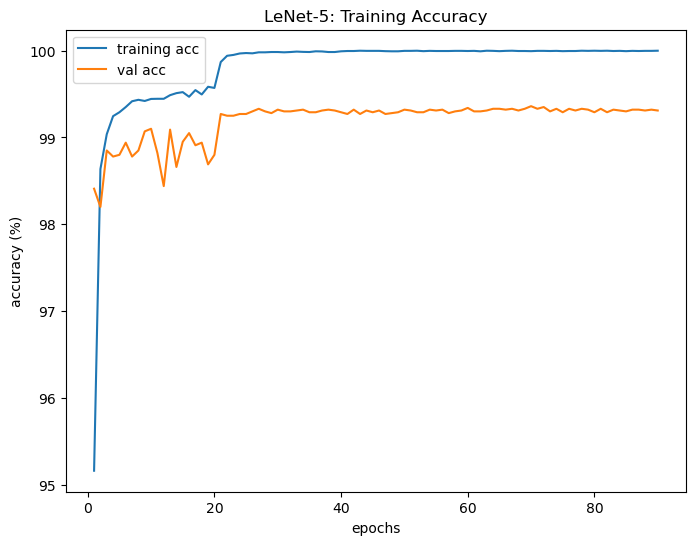

In [21]:
plt.figure(figsize = (8, 6))
plt.plot(list(train_history.keys()), [train_history[k]['train_acc'] for k in train_history.keys()], label = 'training acc')
plt.plot(list(train_history.keys()), [train_history[k]['val_acc'] for k in train_history.keys()], label = 'val acc')
plt.title("LeNet-5: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

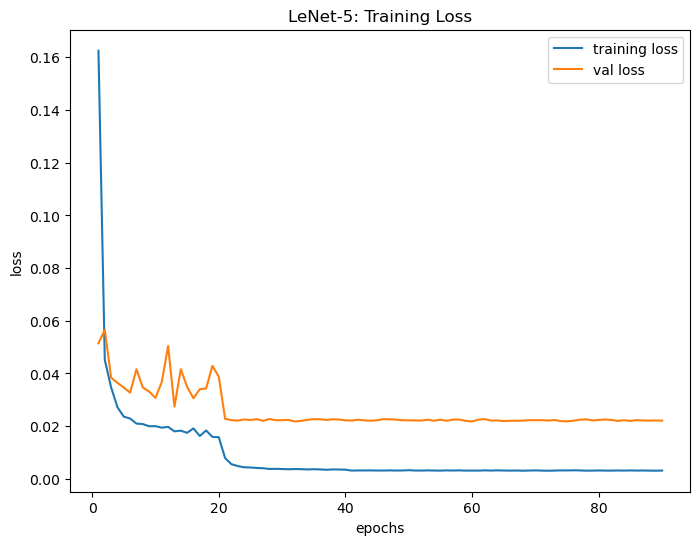

In [22]:
plt.figure(figsize = (8, 6))
plt.plot(list(train_history.keys()), [train_history[k]['train_loss'] for k in train_history.keys()], label = 'training loss')
plt.plot(list(train_history.keys()), [train_history[k]['val_loss'] for k in train_history.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("LeNet-5: Training Loss")
plt.show()

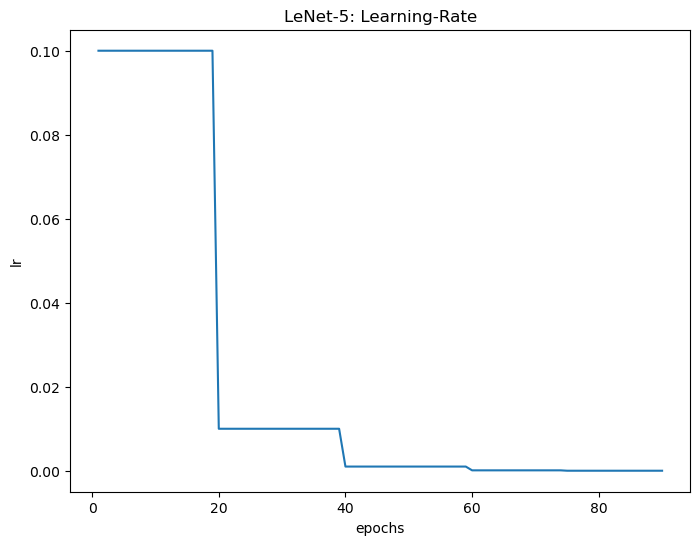

In [23]:
plt.figure(figsize = (8, 6))
plt.plot(list(train_history.keys()), [train_history[k]['lr'] for k in train_history.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("LeNet-5: Learning-Rate")
plt.show()

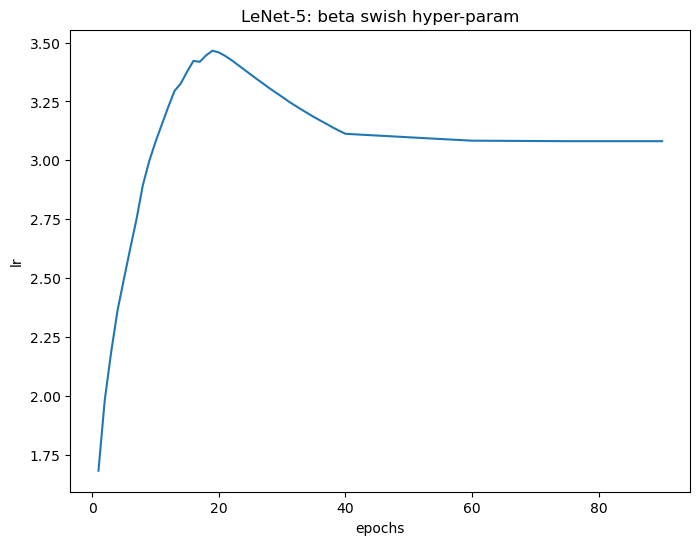

In [24]:
plt.figure(figsize = (8, 6))
plt.plot(list(train_history.keys()), [train_history[k]['beta'] for k in train_history.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("LeNet-5: beta swish hyper-param")
plt.show()

In [ ]:
del model

In [27]:
# Load best trained parameters from before-
best_model = LeNet5().to(device)
best_model.load_state_dict(torch.load("LeNet5_MNIST_best_val_acc.pth"))

<All keys matched successfully>

In [28]:
# Get validation metrics after 1 epoch of training-
val_loss, val_acc = test_one_step(
    model = best_model, test_loader = test_loader,
    test_dataset = test_dataset
)

Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.65batch/s, val_acc=99.4, val_loss=0.0222]


In [29]:
loss, acc = test_one_step(
    model = best_model, test_loader = train_loader,
    test_dataset = train_dataset
)

Validation: : 100%|████████████████████████████████| 235/235 [00:09<00:00, 23.82batch/s, val_acc=100, val_loss=0.00238]


In [30]:
print("LeNet-5 'best' trained validation metrics: ",
      f"loss: {val_loss:.4f} & accuracy = {val_acc:.2f}%"
     )
print("LeNet-5 'best' trained train metrics: ",
      f"loss: {loss:.4f} & accuracy = {acc:.2f}%"
     )

LeNet-5 'best' trained validation metrics:  loss: 0.0222 & accuracy = 99.36%
LeNet-5 'best' trained train metrics:  loss: 0.0024 & accuracy = 100.00%


In [34]:
# max([train_history[k]['val_acc'] for k in train_history.keys()])
max_val_acc = 0
max_epoch = 0

for e in train_history.keys():
    if train_history[e]['val_acc'] > max_val_acc:
        max_val_acc = train_history[e]['val_acc']
        max_epoch = e

In [35]:
max_epoch, max_val_acc

(70, 99.35999298095703)

In [40]:
print(f"highest val acc = {train_history[max_epoch]['val_acc']:.2f}%",
      f" is obtained for beta = {train_history[max_epoch]['beta']:.4f}"
)

highest val acc = 99.36%  is obtained for beta = 3.0820
